In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import uproot

import histlite as hl

import scipy.interpolate as interp

from scipy.optimize import curve_fit

from matplotlib import colors

pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
relevant_runs = ['30254',
                '30255',
                '30256',
                '30257',
                '30258']



replayed_data_dir = '/p/lustre1/lenardo1/tunl_cs136_data/replayed/'

datadict = {}

for run in relevant_runs:
    
    print('Loading {}...'.format(run))
    
    datadir = replayed_data_dir + 'slurm_run{}/'.format(run)
    
    rootfiles = [filename for filename in os.listdir(datadir) \
                                         if filename.endswith('.root')]
    
    data_list = []
    
    for i,thisfile in enumerate(rootfiles):
        if i % 10 == 0:
            print('\tOpening {} of {}'.format(i,len(rootfiles)))

        fullpath = datadir + thisfile

        data_list.append( uproot.open(fullpath)['gamma_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
        
        
    data = pd.concat(data_list,ignore_index=True)   
    
    datadict[run] = data
        

Loading 30254...
	Opening 0 of 11
	Opening 10 of 11
Loading 30255...
	Opening 0 of 9
Loading 30256...
	Opening 0 of 7
Loading 30257...
	Opening 0 of 8
Loading 30258...
	Opening 0 of 11
	Opening 10 of 11


0.2712466062846924
0.2787443306358869
0.2580798572656663
0.24390231452820185
0.25224362045287596


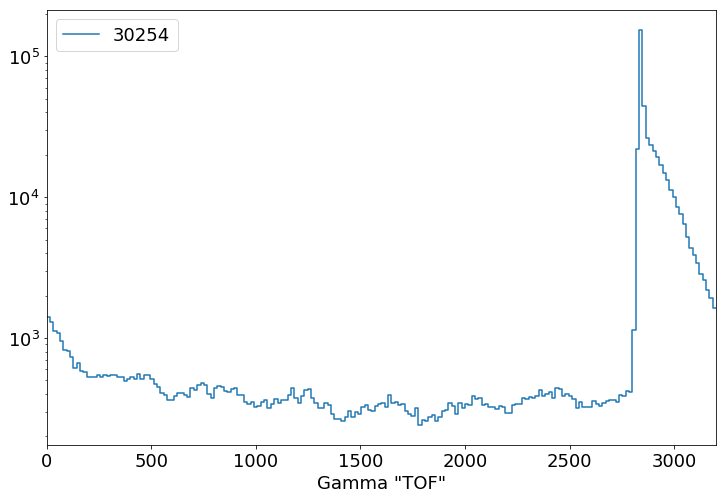

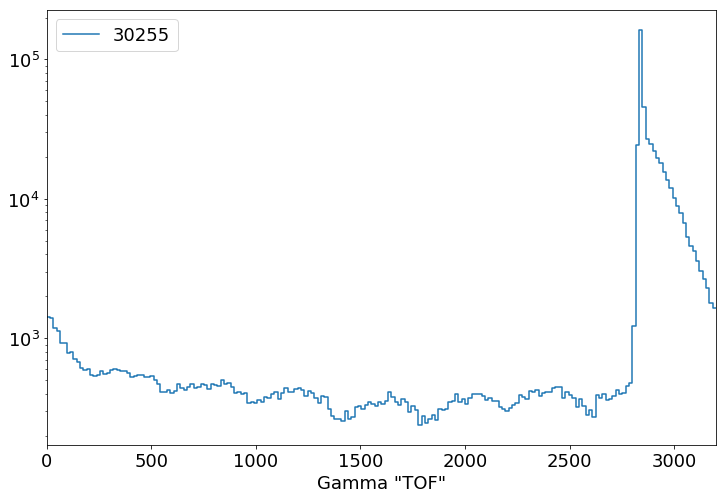

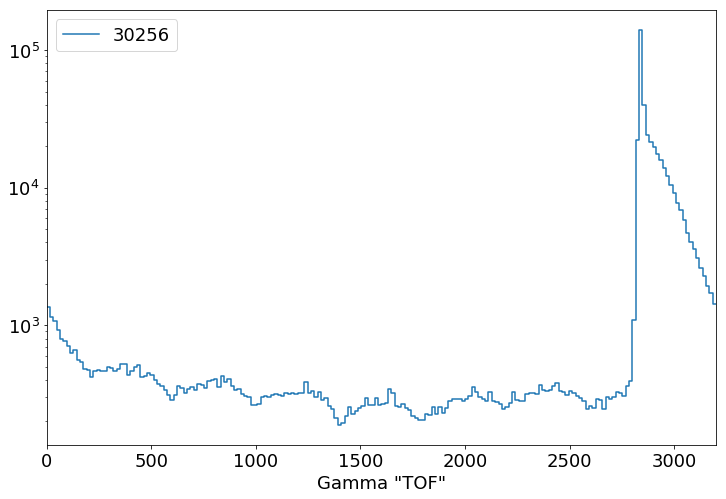

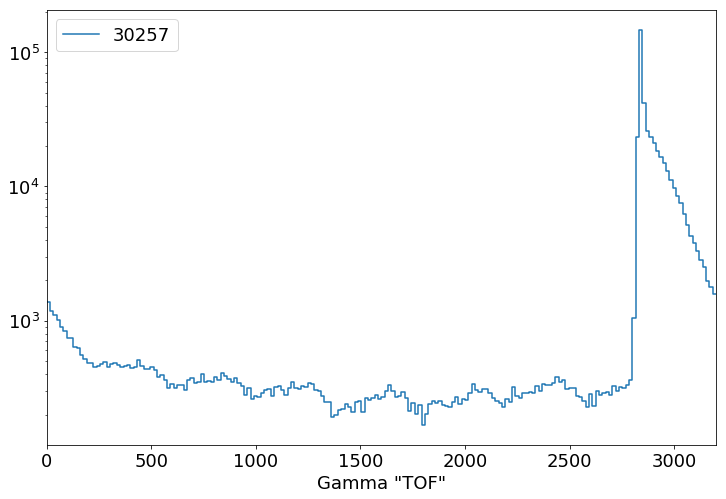

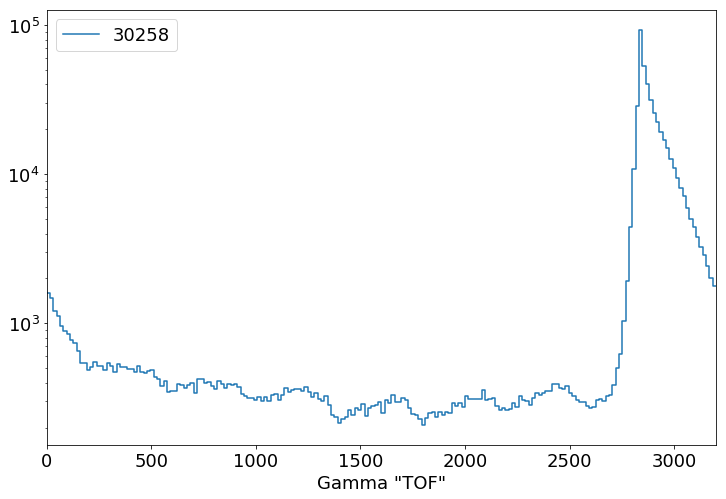

In [5]:

for i,run in enumerate(relevant_runs):
    
    emask = (datadict[run]['gamma_PH'] * 0.6219 > 0.) & \
              (datadict[run]['gamma_PH'] * 0.6219 < 2000.)&\
            (datadict[run]['gamma_ch']==27)  
    
    #thismask = (datadict[run]['gamma_t25']>75.)&(datadict[run]['gamma_t25']<100.)&\
    thismask = (datadict[run]['gamma_t50'] - datadict[run]['gamma_t10']>15)&\
        (datadict[run]['gamma_t50'] - datadict[run]['gamma_t10']<55)#&\
        #(TOFdata>1800.)&(TOFdata<2400.)
    
    
    print(np.sum(emask)/len(emask))
    
    plt.figure(i)
    h_tof = hl.hist(datadict[run]['gamma_tof'].loc[emask&thismask], \
                    bins=np.linspace(0.,3200.,201))
    hl.plot1d(h_tof, label=run)
    

    plt.xlabel('Gamma \"TOF\"')
    plt.xlim(0.,3200.)

    plt.legend()

    plt.yscale('log')   

# Calibrating the $t_0$

In [27]:
def Gaussian( x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def GetBinCenters( histlite_hist ):
    return (histlite_hist.bins[0][1:] + histlite_hist.bins[0][:-1])/2.

import scipy.optimize as opt

0.005391332824708035
0.0057099992315032
0.00515180770702095
0.004761258906168308
0.00504443283699466


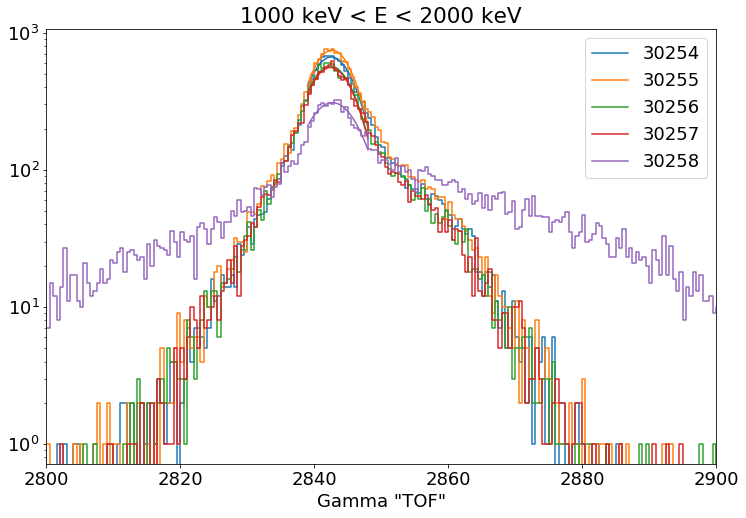

In [37]:
t0_dict = {}

for i,run in enumerate(relevant_runs):
    
    # Do cuts, make histgrams
    emask = (datadict[run]['gamma_PH'] * 0.6219 > 1000.) & \
              (datadict[run]['gamma_PH'] * 0.6219 < 2000.)&\
            (datadict[run]['gamma_ch']==27)  
    
    #thismask = (datadict[run]['gamma_t25']>75.)&(datadict[run]['gamma_t25']<100.)&\
    thismask = (datadict[run]['gamma_t50'] - datadict[run]['gamma_t10']>15)&\
        (datadict[run]['gamma_t50'] - datadict[run]['gamma_t10']<55)#&\
        #(TOFdata>1800.)&(TOFdata<2400.)
    
    
    print(np.sum(emask)/len(emask))
    plt.figure(1)
    h_tof = hl.hist(datadict[run]['gamma_tof'].loc[emask&thismask], \
                    bins=np.linspace(0.,3200.,6401))
    hl.plot1d(h_tof, label=run, color=pltcolors[i])
    

    
    # Do fits
    bincenters = GetBinCenters(h_tof)
    vals = h_tof.values
    
    fitmin = 2839
    fitmax = 2848
    
    fitmask = (bincenters > fitmin)&(bincenters < fitmax)
    
#     print(vals[fitmask])
    
    p,pcov = opt.curve_fit( Gaussian, bincenters[fitmask], vals[fitmask],\
                 p0 = (1000.,2842.,3.))
    
#     print(p)
    
    xfit = np.linspace(fitmin,fitmax,100)
#     print(xfit)
    yfit = Gaussian(xfit,p[0],p[1],p[2])
    #yfit = Gaussian(xfit,1000.,2845.,3.)
#     print(yfit)
 

    plt.plot( xfit, yfit, color=pltcolors[i])
    

    
    
    
    plt.xlabel('Gamma \"TOF\"')
    plt.xlim(2800.,2900.)
    
    plt.title('1000 keV < E < 2000 keV')
    

    plt.legend()

    plt.yscale('log')
    
    t0_dict[run] = p[1]

In [38]:
print(t0_dict)

{'30254': 2842.5435954222553, '30255': 2842.636271757656, '30256': 2842.3769889858927, '30257': 2842.426044278175, '30258': 2842.7213319463463}


In [49]:
for i,run in enumerate(relevant_runs):
    
    offset = 300
    
    datadict[run]['corrected_tof'] = \
            np.fmod(datadict[run]['gamma_tof'] + \
                        (3200 - t0_dict[run])+offset, 3200.) - offset

# Sum the good runs, look at high-stats data



In [51]:
good_runs = ['30254',
                '30255',
                '30256',
                '30257']

master_df_list = []

for run in good_runs:
    master_df_list.append(datadict[run])
    
master_df = pd.concat(master_df_list, ignore_index=True)

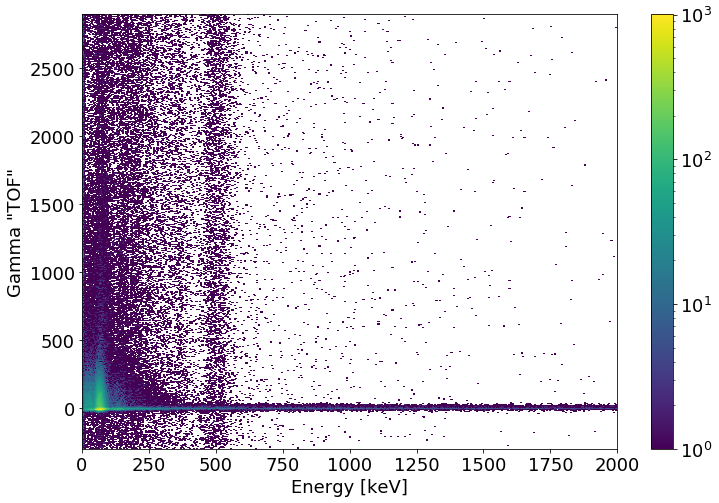

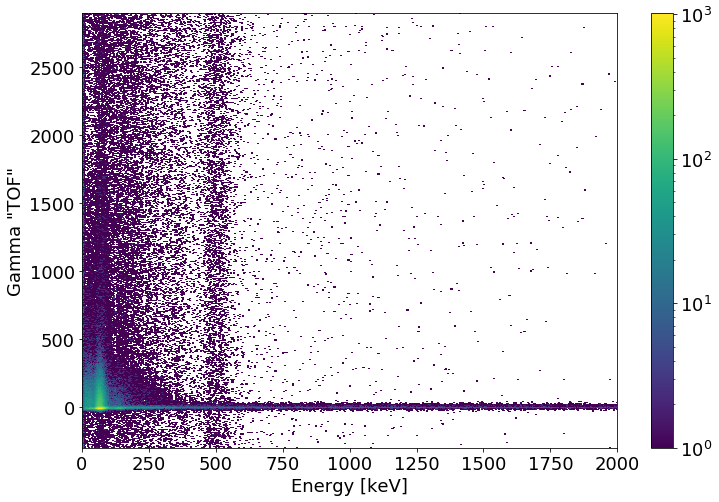

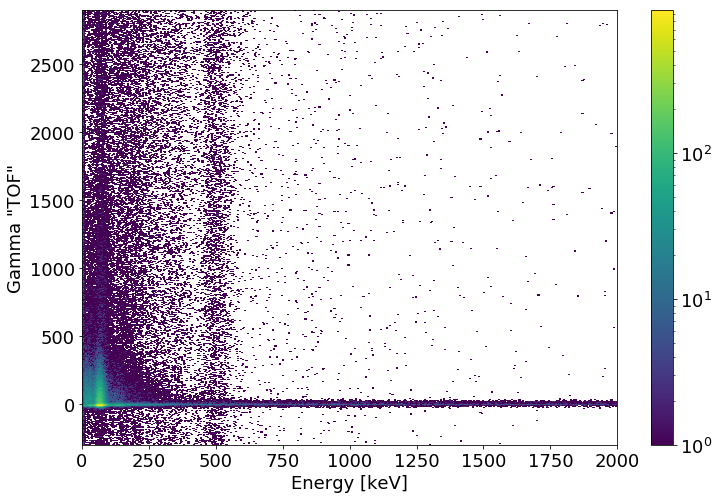

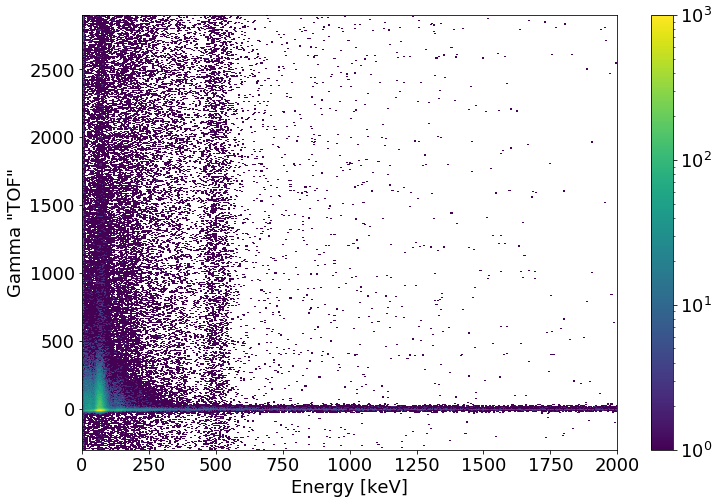

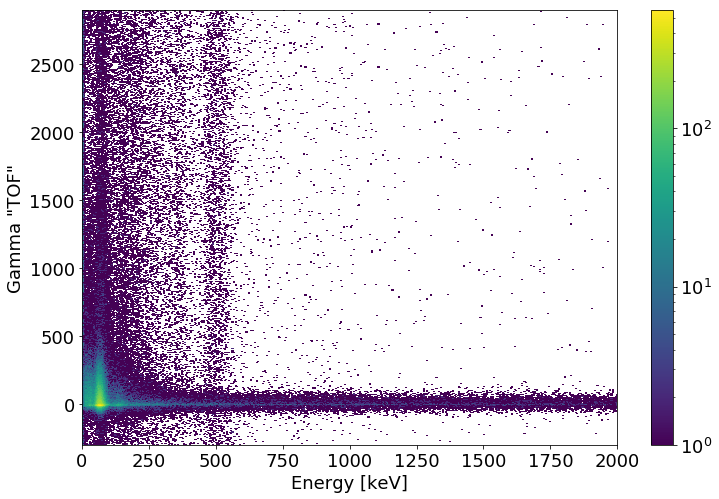

In [50]:
for i,run in enumerate(relevant_runs):
    
    emask = (datadict[run]['gamma_PH'] * 0.6219 > 0.) & \
              (datadict[run]['gamma_PH'] * 0.6219 < 2000.)&\
            (datadict[run]['gamma_ch']==27)
    
    #thismask = (datadict[run]['gamma_t25']>75.)&(datadict[run]['gamma_t25']<100.)&\
    thismask = (datadict[run]['gamma_t50'] - datadict[run]['gamma_t10']>15)&\
        (datadict[run]['gamma_t50'] - datadict[run]['gamma_t10']<55)#&\
        #(TOFdata>1800.)&(TOFdata<2400.)
    
    
    plt.figure(i)

    plt.hist2d( datadict[run]['gamma_PH'].loc[emask&thismask] * 0.6219,\
                 datadict[run]['corrected_tof'].loc[emask&thismask], \
               bins=[np.linspace(0.,2000.,500),np.linspace(-300.,2900,3200)],\
                            norm=colors.LogNorm() )
    plt.xlabel('Energy [keV]')
    plt.ylabel('Gamma \"TOF\"')
    plt.xlim(0.,2000.)
    plt.ylim(-300.,2900.)
    plt.colorbar()
    


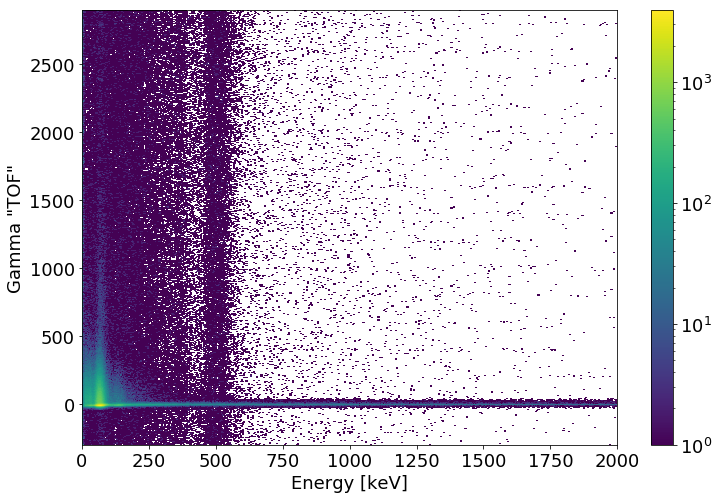

In [53]:
emask = (master_df['gamma_PH'] * 0.6219 > 0.) & \
          (master_df['gamma_PH'] * 0.6219 < 2000.)&\
        (master_df['gamma_ch']==27)

#thismask = (master_df['gamma_t25']>75.)&(master_df['gamma_t25']<100.)&\
thismask = (master_df['gamma_t50'] - master_df['gamma_t10']>15)&\
    (master_df['gamma_t50'] - master_df['gamma_t10']<55)#&\
    #(TOFdata>1800.)&(TOFdata<2400.)


plt.hist2d( master_df['gamma_PH'].loc[emask&thismask] * 0.6219,\
             master_df['corrected_tof'].loc[emask&thismask], \
           bins=[np.linspace(0.,2000.,500),np.linspace(-300.,2900,3200)],\
                        norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('Gamma \"TOF\"')
plt.xlim(0.,2000.)
plt.ylim(-300.,2900.)
plt.colorbar()

plt.savefig('Plots/LowCurrentBkgAnalysis/pmt_summed_energy_vs_tof_t50mt10_quality_cuts.png',\
            dpi=200,\
           bbox_inches='tight')



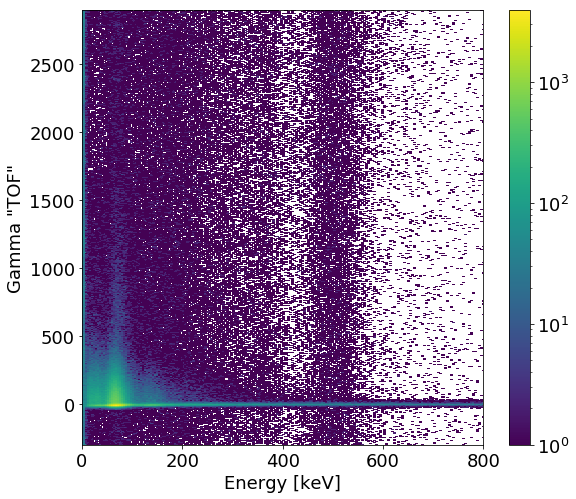

In [86]:
emask = (master_df['gamma_PH'] * 0.6219 > 0.) & \
          (master_df['gamma_PH'] * 0.6219 < 2000.)&\
        (master_df['gamma_ch']==27)

#thismask = (master_df['gamma_t25']>75.)&(master_df['gamma_t25']<100.)&\
thismask = (master_df['gamma_t50'] - master_df['gamma_t10']>15)&\
    (master_df['gamma_t50'] - master_df['gamma_t10']<55)#&\
    #(TOFdata>1800.)&(TOFdata<2400.)


plt.hist2d( master_df['gamma_PH'].loc[emask&thismask] * 0.6219,\
             master_df['corrected_tof'].loc[emask&thismask], \
           bins=[np.linspace(0.,2000.,500),np.linspace(-300.,2900,3200)],\
                        norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('Gamma \"TOF\"')
plt.xlim(0.,800.)
plt.ylim(-300.,2900.)
plt.colorbar()

plt.savefig('Plots/LowCurrentBkgAnalysis/pmt_summed_energy_vs_tof_t50mt10_quality_cuts_zoomed.png',\
            dpi=200,\
           bbox_inches='tight')




In [60]:
emask = (master_df['gamma_PH'] * 0.6219 > 0.) & \
          (master_df['gamma_PH'] * 0.6219 < 2000.)&\
        (master_df['gamma_ch']==27)

qualitymask = (master_df['gamma_t50'] - master_df['gamma_t10']>15)&\
    (master_df['gamma_t50'] - master_df['gamma_t10']<55)


long_tofmask = (master_df['corrected_tof'] > 2500.)& \
            (master_df['corrected_tof'] < 3000.)

short_tofmask = (master_df['corrected_tof'] > 100.)& \
            (master_df['corrected_tof'] < 300.)

prompt_tofmask = (master_df['corrected_tof'] > -50.)& \
            (master_df['corrected_tof'] < 50.)

fullmask = emask & qualitymask & prompt_tofmask
h_prompt = hl.hist( master_df['gamma_PH'].loc[fullmask]* 0.6219,\
                  bins=np.linspace(0.,800.,200))

fullmask = emask & qualitymask & short_tofmask
h_short = hl.hist( master_df['gamma_PH'].loc[fullmask]* 0.6219,\
                  bins=np.linspace(0.,800.,200))

fullmask = emask & qualitymask & long_tofmask
h_long = hl.hist( master_df['gamma_PH'].loc[fullmask]* 0.6219,\
                  bins=np.linspace(0.,800.,200))





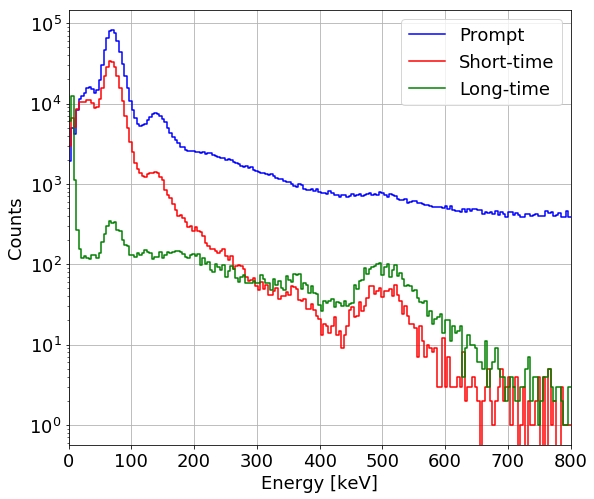

In [63]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (9,8)

hl.plot1d(h_prompt,color='b',label='Prompt')
hl.plot1d(h_short, color='r',label='Short-time')
hl.plot1d(h_long, color='g',label='Long-time')

plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlim(0.,800.)

plt.savefig('Plots/LowCurrentBkgAnalysis/pmt_energy_spectra_different_time_slices.png',\
            dpi=200,bbox_inches='tight')


# Time dependence

In [119]:
emask_511 = (master_df['gamma_PH'] * 0.6219 > 450.) & \
          (master_df['gamma_PH'] * 0.6219 < 550.)&\
        (master_df['gamma_ch']==27)

emask_366 = (master_df['gamma_PH'] * 0.6219 > 320.) & \
          (master_df['gamma_PH'] * 0.6219 < 400.)&\
        (master_df['gamma_ch']==27)

emask_75 = (master_df['gamma_PH'] * 0.6219 > 50.) & \
          (master_df['gamma_PH'] * 0.6219 < 100.)&\
        (master_df['gamma_ch']==27)



qualitymask = (master_df['gamma_t50'] - master_df['gamma_t10']>15)&\
    (master_df['gamma_t50'] - master_df['gamma_t10']<55)
#qualitymask = np.ones(len(master_df),dtype=bool)

nbins_t = 801

fullmask = emask_511 & qualitymask

h_511 = hl.hist( master_df['corrected_tof'].loc[fullmask],\
                  bins = np.linspace(-300.,2900.,nbins_t))

fullmask = emask_366 & qualitymask
h_366 = hl.hist( master_df['corrected_tof'].loc[fullmask],\
                  bins = np.linspace(-300.,2900.,nbins_t))

fullmask = emask_75 & qualitymask
h_75 = hl.hist( master_df['corrected_tof'].loc[fullmask],\
                  bins = np.linspace(-300.,2900.,nbins_t))

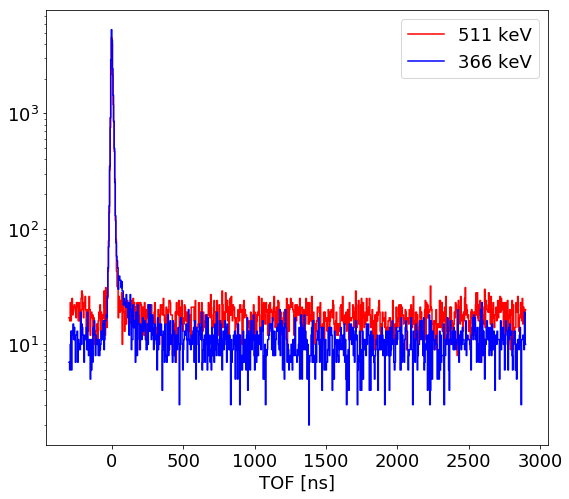

In [123]:
hl.plot1d(h_511, color='r', label='511 keV')
hl.plot1d(h_366, color='b', label='366 keV')
#hl.plot1d(h_75, color='r', label='75 keV')


plt.yscale('log')
#plt.ylim(-10.,30.)

plt.xlabel('TOF [ns]')
plt.legend()

plt.savefig('Plots/LowCurrentBkgAnalysis/pmt_time_spectra_higher_e_gammas.png',
           dpi=200,bbox_inches='tight')





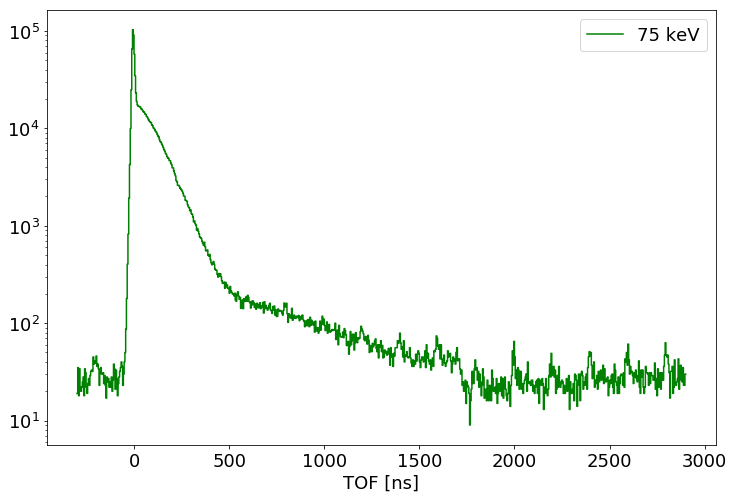

In [126]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12,8)

hl.plot1d(h_75, color='g', label='75 keV')


plt.yscale('log')
#plt.ylim(-10.,30.)

plt.xlabel('TOF [ns]')
plt.legend()


plt.savefig('Plots/LowCurrentBkgAnalysis/pmt_time_spectra_75keV_gammas.png',
           dpi=200,bbox_inches='tight')



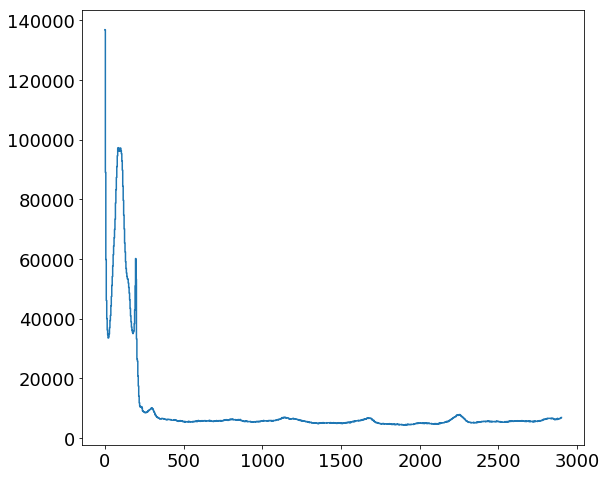

In [ ]:
# Waveforms

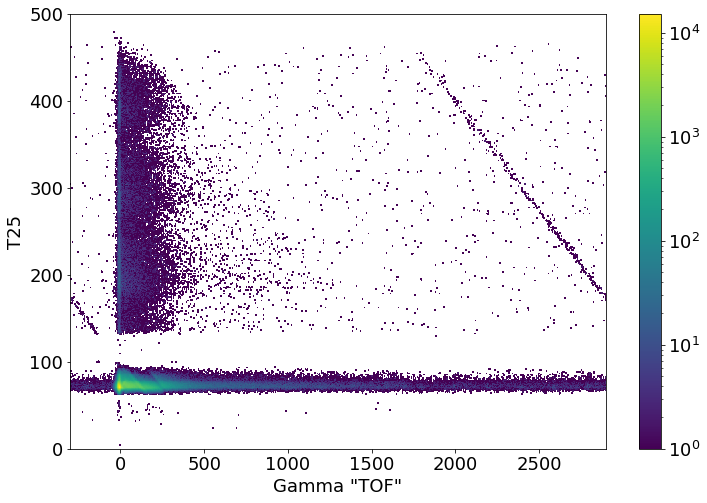

In [130]:
emask = (master_df['gamma_PH'] * 0.6219 > 50.) & \
          (master_df['gamma_PH'] * 0.6219 < 100.)&\
        (master_df['gamma_ch']==27)

#thismask = (master_df['gamma_t25']>75.)&(master_df['gamma_t25']<100.)&\
thismask = (master_df['gamma_t50'] - master_df['gamma_t10']>15)&\
    (master_df['gamma_t50'] - master_df['gamma_t10']<55)#&\
    #(TOFdata>1800.)&(TOFdata<2400.)


plt.hist2d( master_df['corrected_tof'].loc[emask&thismask],\
             master_df['gamma_t10'].loc[emask&thismask], \
           bins=[np.linspace(-300.,2900.,801),np.linspace(0.,500.,501)],\
                        norm=colors.LogNorm() )
plt.xlabel('Gamma \"TOF\"')
plt.ylabel('T25')
plt.ylim(0.,500.)
plt.xlim(-300.,2900.)
plt.colorbar()

In [16]:
mask_pmt = data['gamma_ch'] == 27

data_pmt = data.loc[mask_pmt]

data_pmt.head()


,gamma_ch,gamma_PH,gamma_E,gamma_ts,gamma_tof,gamma_PSD,gamma_flash,gamma_true_time,gamma_t10,gamma_t25,gamma_t50,gamma_t90
10,27.0,12.233333,0.0,7.811336e+10,2524.430494,8.0,0.0,2524.430494,78.0,99.0,227.0,406.0
19,27.0,3.050000,0.0,7.811683e+10,359.556979,8.0,0.0,359.556979,0.0,0.0,3.0,244.0
21,27.0,109.125000,0.0,7.811684e+10,1916.051790,8.0,0.0,1916.051790,70.0,79.0,100.0,156.0
23,27.0,103.441667,0.0,7.811745e+10,1961.986255,8.0,0.0,1961.986255,70.0,84.0,106.0,219.0
26,27.0,118.508333,0.0,7.812006e+10,1816.449403,8.0,0.0,1816.449403,69.0,79.0,102.0,180.0


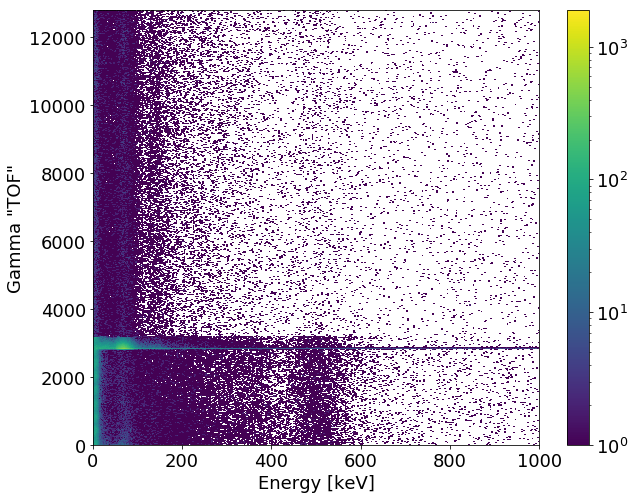

In [17]:


plt.hist2d( data_pmt['gamma_PH'] * 0.6219,\
                 data_pmt['gamma_tof'], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,12800,3200)],\
                            norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('Gamma \"TOF\"')
plt.xlim(0.,1000.)
plt.colorbar()

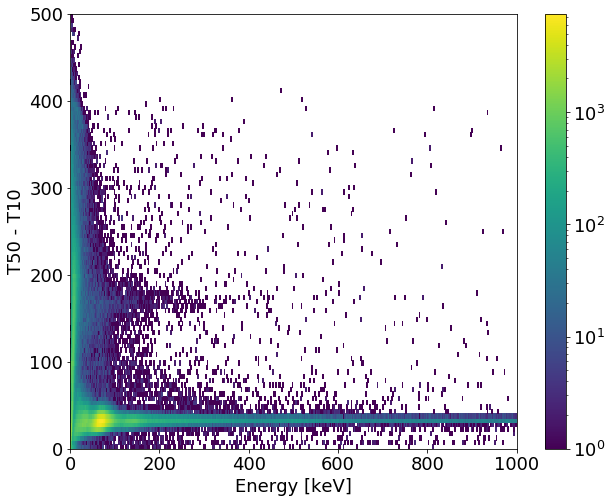

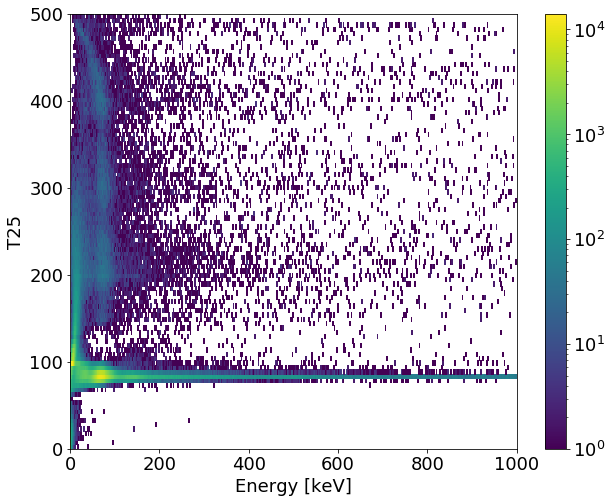

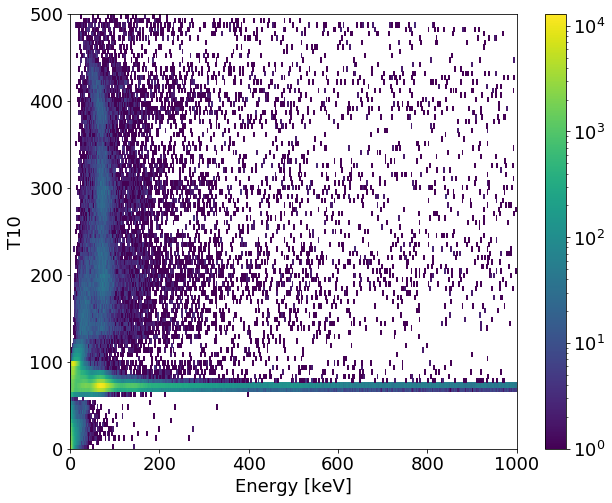

In [18]:
mask = (data_pmt['gamma_tof']>2000.)&(data_pmt['gamma_tof']<10000.)

plt.hist2d( data_pmt['gamma_PH'].loc[mask] * 0.6219,\
                 data_pmt['gamma_t50'].loc[mask] - data_pmt['gamma_t10'].loc[mask], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,100)],\
                            norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('T50 - T10')
plt.xlim(0.,1000.)
#plt.ylim(0.,200.)
plt.colorbar()

plt.figure(2)
#mask = (data_pmt['gamma_tof']>2000.)&(data_pmt['gamma_tof']<10000.)

plt.hist2d( data_pmt['gamma_PH'].loc[mask] * 0.6219,\
                 data_pmt['gamma_t25'].loc[mask], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,100)],\
                            norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('T25')
plt.xlim(0.,1000.)
plt.colorbar()

plt.figure(3)
#mask = (data_pmt['gamma_tof']>2000.)&(data_pmt['gamma_tof']<10000.)

plt.hist2d( data_pmt['gamma_PH'].loc[mask] * 0.6219,\
                 data_pmt['gamma_t10'].loc[mask], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,100)],\
                            norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('T10')
plt.xlim(0.,1000.)
plt.colorbar()


(0.0, 3200.0)

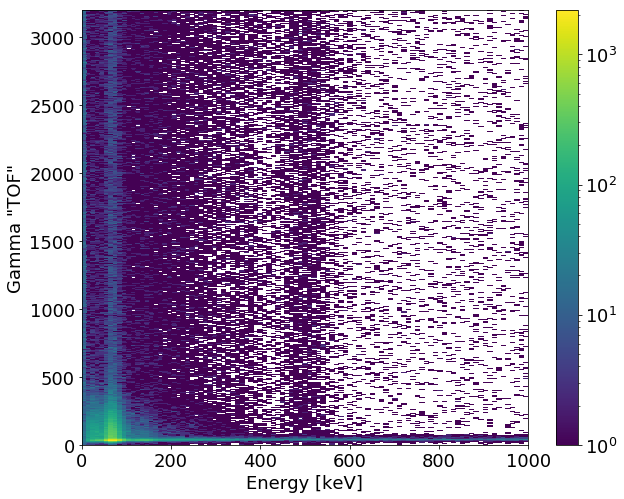

In [19]:
mask = (data_pmt['gamma_t25']>75.)&(data_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)

plt.hist2d( data_pmt['gamma_PH'].loc[mask] * 0.6219,\
                 np.fmod(data_pmt['gamma_tof'].loc[mask]+400,3200.), \
               bins=[np.linspace(0.,1000.,100),np.linspace(0.,3200,3200)],\
                            norm=colors.LogNorm() )

TOFdata = np.fmod(data_pmt['gamma_tof']+400,3200.)

plt.xlabel('Energy [keV]')
plt.ylabel('Gamma \"TOF\"')
plt.xlim(0.,1000.)
plt.colorbar()
           
plt.ylim(0.,3200.)

(0.0, 200.0)

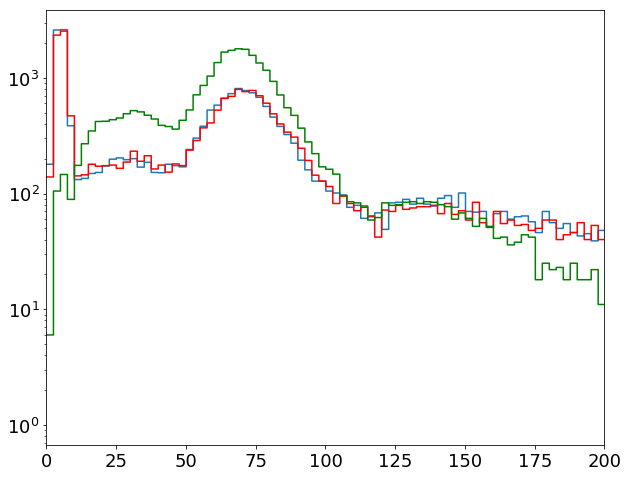

In [20]:
thismask = (data_pmt['gamma_t25']>75.)&(data_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)&\
        (TOFdata>1800.)&(TOFdata<2400.)
    
h_delayed_energy = hl.hist(data_pmt['gamma_PH'].loc[thismask]*0.6219, bins=np.linspace(0.,2000.,800))

hl.plot1d(h_delayed_energy)

plt.yscale('log')





thismask = (data_pmt['gamma_t25']>75.)&(data_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)&\
        (TOFdata>1000.)&(TOFdata<1500.)
    
h_delayed_energy2 = hl.hist(data_pmt['gamma_PH'].loc[thismask]*0.6219, bins=np.linspace(0.,2000.,800))

hl.plot1d(h_delayed_energy2,color='r')

plt.yscale('log')





thismask = (data_pmt['gamma_t25']>75.)&(data_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)&\
        (TOFdata>80.)&(TOFdata<100.)
    
h_prompt_energy = hl.hist(data_pmt['gamma_PH'].loc[thismask]*0.6219, bins=np.linspace(0.,2000.,800))

hl.plot1d(h_prompt_energy,color='g')

plt.yscale('log')

plt.xlim(0.,200.)




In [60]:
import pickle

datalist = []

for i in range(30):
    filename = replayed_data_dir + 'run30201_{}_nai_pmt_waveforms.pkl'.format(i)
    with open( filename ,'rb') as pklfile:
        datalist.extend(pickle.load(pklfile))
    
datadf = pd.DataFrame(datalist)


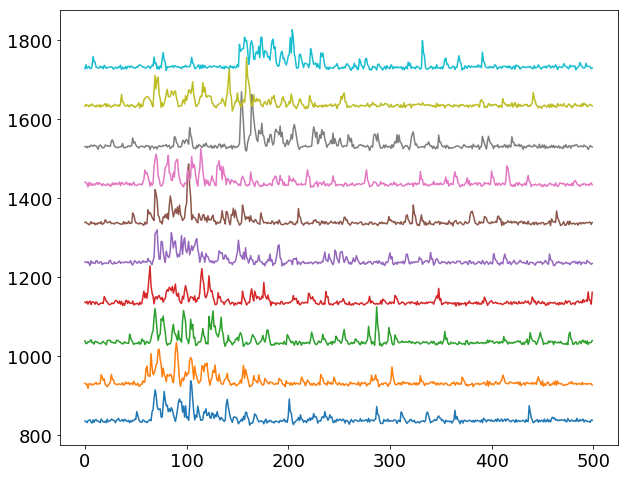

In [66]:
mask = (datadf['t50'] - datadf['t10']>15)&\
        (datadf['t50'] - datadf['t10']<55)&\
        (datadf['peakhigh_reported']* 0.6219 < 50)&\
        (datadf['peakhigh_reported']* 0.6219 > 30)
        

dfmask = datadf.loc[mask]

for i in range(10):
    try:
        plt.plot(dfmask['samples'].iloc[i] + 100*i)
    except IndexError:
        break

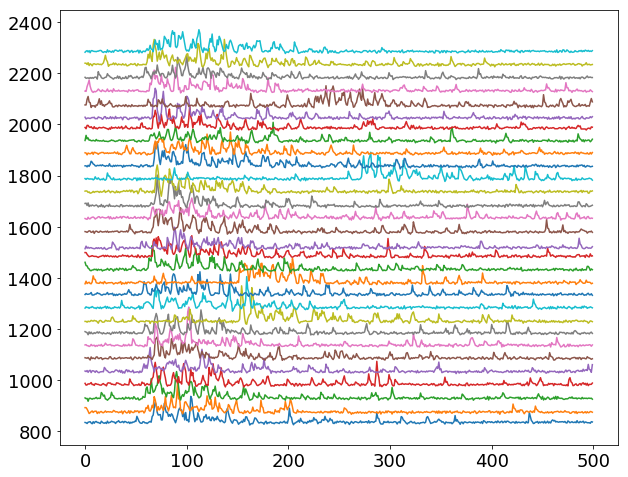

In [79]:
mask = (datadf['t50'] - datadf['t10']>15)&\
        (datadf['t50'] - datadf['t10']<55)&\
         (datadf['peakhigh_reported']* 0.6219 > 20)&\
         (datadf['peakhigh_reported']* 0.6219 < 50)
        

dfmask = datadf.loc[mask]

for i in range(30):
    try:
        plt.plot(dfmask['samples'].iloc[i] + 50*i)
    except IndexError:
        break

In [ ]:
mask = (datadf['t25']>75.)&(datadf['t25']<100.)&\
        (datadf['t50'] - datadf['t10']>75)&\
        (datadf['t50'] - datadf['t10']<125)&\
        (datadf['peakhigh_reported']* 0.6219 < 50)&\
        (datadf['peakhigh_reported']* 0.6219 > 30)
        

dfmask = datadf.loc[mask]

for i in range(10):
    try:
        plt.plot(dfmask['samples'].iloc[i] + 100*i)
    except IndexError:
        break